In [1]:
# imports

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorly as tl
from sklearn.decomposition import PCA
import umap
import xarray as xr


/Users/blasks/Library/Caches/pypoetry/virtualenvs/stromatolite-paper-AG5eZpWO-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# keywargs for annotating panels
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}


In [3]:
# helpful functions

# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(vector + pseudocount))) - pseudocount


# Read in data

In [4]:
# read in sample metadata

filepath_sample_metadata = '../../data/metadata/sample_metadata.csv'
sample_df = pd.read_csv(filepath_sample_metadata)
sample_df['Cruise'] = sample_df['Cruise'].map({'kok1606': 'G1', 
                                               'mgl1704': 'G2', 
                                               'km1906': 'G3'})
sample_df['samplename'] = [name[:-2] for name in sample_df['SampleID']]
sample_df = sample_df.rename(columns={'SampleID': 'sample', 'Replicate': 'replicate'})

sample_df


sample Cruise               Dataset Experiment  Station  \
0    G1.SURF.NS.S02C1.15m.A     G1   Gradients 1 surface        NaN      2.0   
1    G1.SURF.NS.S02C1.15m.B     G1   Gradients 1 surface        NaN      2.0   
2    G1.SURF.NS.S02C1.15m.C     G1   Gradients 1 surface        NaN      2.0   
3    G1.SURF.NS.S04C1.15m.A     G1   Gradients 1 surface        NaN      4.0   
4    G1.SURF.NS.S04C1.15m.B     G1   Gradients 1 surface        NaN      4.0   
..                      ...    ...                   ...        ...      ...   
217    G3.UW.NS.UW40_1.7m.B     G3  Gradients 3 underway        NaN      NaN   
218    G3.UW.NS.UW40_1.7m.C     G3  Gradients 3 underway        NaN      NaN   
219    G3.UW.NS.UW40_2.7m.A     G3  Gradients 3 underway        NaN      NaN   
220    G3.UW.NS.UW40_2.7m.B     G3  Gradients 3 underway        NaN      NaN   
221    G3.UW.NS.UW40_2.7m.C     G3  Gradients 3 underway        NaN      NaN   

     Cast      Datetime   Latitude   Longitude  Depth replicate  \
0     1.0  4/20/16 5:51  23.495833 -157.994333     15         A   
1     1.0  4/20/16 5:51  23.495833 -157.994333     15         B   
2     1.0  4/20/16 5:51  23.495833 -157.994333     15         C   
3     1.0  4/22/16 5:40  28.143167 -158.000667     15         A   
4     1.0  4/22/16 5:40  28.143167 -158.000667     15         B   
..    ...           ...        ...         ...    ...       ...   
217   NaN  4/24/19 5:57  40.880000 -158.000000      7         B   
218   NaN  4/24/19 5:57  40.880000 -158.000000      7         C   
219   NaN  4/25/19 6:01  40.090000 -158.000000      7         A   
220   NaN  4/25/19 6:01  40.090000 -158.000000      7         B   
221   NaN  4/25/19 6:01  40.090000 -158.000000      7         C   

                    SmallFraction               LargeFraction  Unfractionated  \
0    G1.SURF.NS.S02C1.15m.0_2um.A  G1.SURF.NS.S02C1.15m.3um.A           False   
1    G1.SURF.NS.S02C1.15m.0_2um.B  G1.SURF.NS.S02C1.15m.3um.B           False   
2    G1.SURF.NS.S02C1.15m.0_2um.C  G1.SURF.NS.S02C1.15m.3um.C           False   
3    G1.SURF.NS.S04C1.15m.0_2um.A  G1.SURF.NS.S04C1.15m.3um.A           False   
4    G1.SURF.NS.S04C1.15m.0_2um.B  G1.SURF.NS.S04C1.15m.3um.B           False   
..                            ...                         ...             ...   
217    G3.UW.NS.UW40_1.7m.0_2um.B    G3.UW.NS.UW40_1.7m.3um.B           False   
218    G3.UW.NS.UW40_1.7m.0_2um.C    G3.UW.NS.UW40_1.7m.3um.C           False   
219    G3.UW.NS.UW40_2.7m.0_2um.A    G3.UW.NS.UW40_2.7m.3um.A           False   
220    G3.UW.NS.UW40_2.7m.0_2um.B    G3.UW.NS.UW40_2.7m.3um.B           False   
221    G3.UW.NS.UW40_2.7m.0_2um.C    G3.UW.NS.UW40_2.7m.3um.C           False   

       Batch            samplename  
0    G1_SURF  G1.SURF.NS.S02C1.15m  
1    G1_SURF  G1.SURF.NS.S02C1.15m  
2    G1_SURF  G1.SURF.NS.S02C1.15m  
3    G1_SURF  G1.SURF.NS.S04C1.15m  
4    G1_SURF  G1.SURF.NS.S04C1.15m  
..       ...                   ...  
217  G3_SURF    G3.UW.NS.UW40_1.7m  
218  G3_SURF    G3.UW.NS.UW40_1.7m  
219  G3_SURF    G3.UW.NS.UW40_2.7m  
220  G3_SURF    G3.UW.NS.UW40_2.7m  
221  G3_SURF    G3.UW.NS.UW40_2.7m  

[222 rows x 16 columns]

In [15]:
# read in normalized data

syn_ds = xr.open_dataset('../../analyses/3-normalization/batch-test/syn-tensor-dataset.nc')
pro_ds = xr.open_dataset('../../analyses/3-normalization/batch-test/pro-tensor-dataset.nc')

syn_ds


<xarray.Dataset>
Dimensions:     (ortholog: 6161, clade: 6, sample: 222)
Coordinates:
  * ortholog    (ortholog) int64 60000001 60000002 ... 60040219 60040245
  * clade       (clade) object '5.1A-I' '5.1A-II' ... '5.1B-VII' 'CDR2'
  * sample      (sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    readcount   (ortholog, clade, sample) float64 ...
    residual    (ortholog, clade, sample) float64 ...
    replicate   (sample) object ...
    samplename  (sample) object ...
    annotation  (ortholog) object ...

# Pre-normalization mean-variance relationship

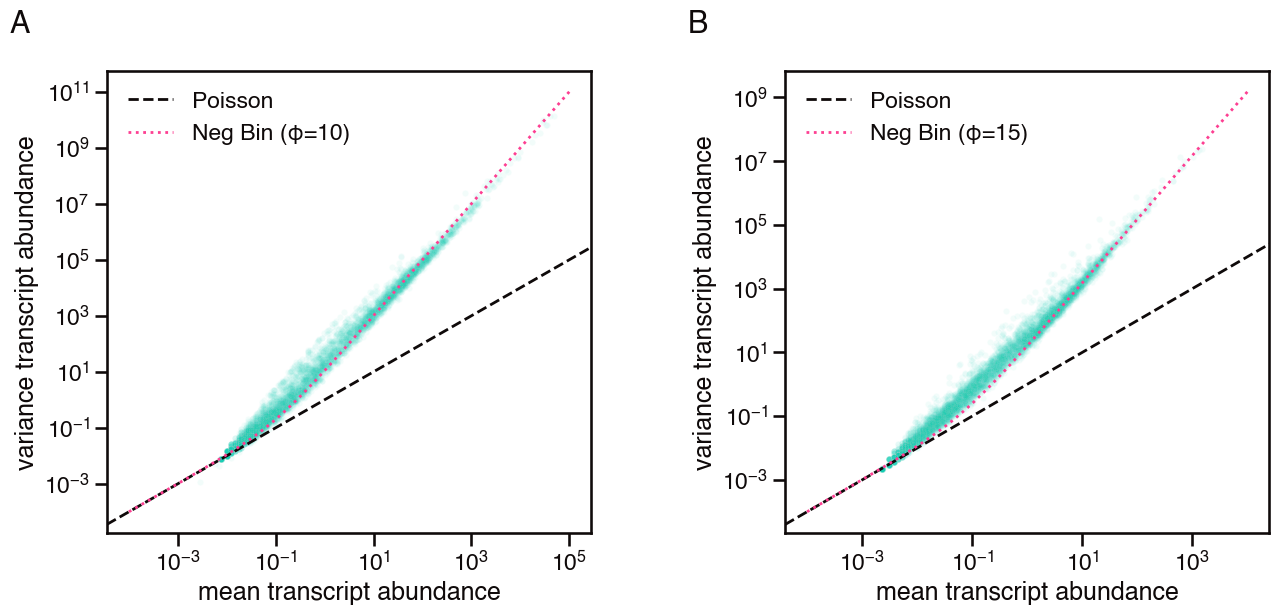

In [6]:
# make figure showing mean-variance relationship of pro and syn data

fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'wspace': .4})

# pull out prochlorococcus read abundance data (pre-normalization)
pro_abun_df = pro_ds.readcount.to_dataframe().reset_index()
pro_abun_df = pro_abun_df.pivot(index='ortholog', columns=['sample', 'clade'], values='readcount')
# set negative binomial parameters
phi = 10
xx = np.logspace(-4, 5, num=248)
yy = xx + phi * np.power(xx, 2)
# plot mean vs. variance scatterplot
sns.scatterplot(
    x=pro_abun_df.mean(axis=1), 
    y=pro_abun_df.var(axis=1), 
    alpha=0.05, 
    s=20, 
    edgecolors=None, 
    color=sns.color_palette()[2], 
    legend=False, 
    ax=axes[0]
)
# plot poisson reference line
axes[0].axline((0, 0), slope=1, linestyle='--', color=sns.color_palette()[4], label='Poisson');
# plot negative binomial reference line
axes[0].plot(xx, yy, linestyle=':', color=sns.color_palette()[3], label='Neg Bin (φ={})'.format(phi));
# set figure parameters and labels
axes[0].annotate('A', xy=(-0.2, 1.1), **annot_kwgs)
axes[0].set(xscale='log', yscale='log', xlabel='mean transcript abundance', ylabel='variance transcript abundance')
axes[0].legend()


# pull out synechococcus read abundance data (pre-normalization)
syn_abun_df = syn_ds.readcount.to_dataframe().reset_index()
syn_abun_df = syn_abun_df.pivot(index='ortholog', columns=['sample', 'clade'], values='readcount')
# set negative binomial parameters
phi = 15
xx = np.logspace(-4, 4, num=248)
yy = xx + phi * np.power(xx, 2)
# plot mean vs. variance scatterplot
sns.scatterplot(
    x=syn_abun_df.mean(axis=1), 
    y=syn_abun_df.var(axis=1), 
    alpha=0.05, 
    s=20, 
    edgecolors=None, 
    color=sns.color_palette()[2], 
    legend=False, 
    ax=axes[1]
)
# plot poisson reference line
axes[1].axline((0, 0), slope=1, linestyle='--', color=sns.color_palette()[4], label='Poisson');
# plot negative binomial reference line
axes[1].plot(xx, yy, linestyle=':', color=sns.color_palette()[3], label='Neg Bin (φ={})'.format(phi));
# set figure parameters and labels
axes[1].annotate('B', xy=(-0.2, 1.1), **annot_kwgs)
axes[1].set(xscale='log', yscale='log', xlabel='mean transcript abundance', ylabel='variance transcript abundance')
axes[1].legend()

plt.savefig('prenorm-var-v-mean.png', bbox_inches='tight')


# Post-normalization mean-variance relationship

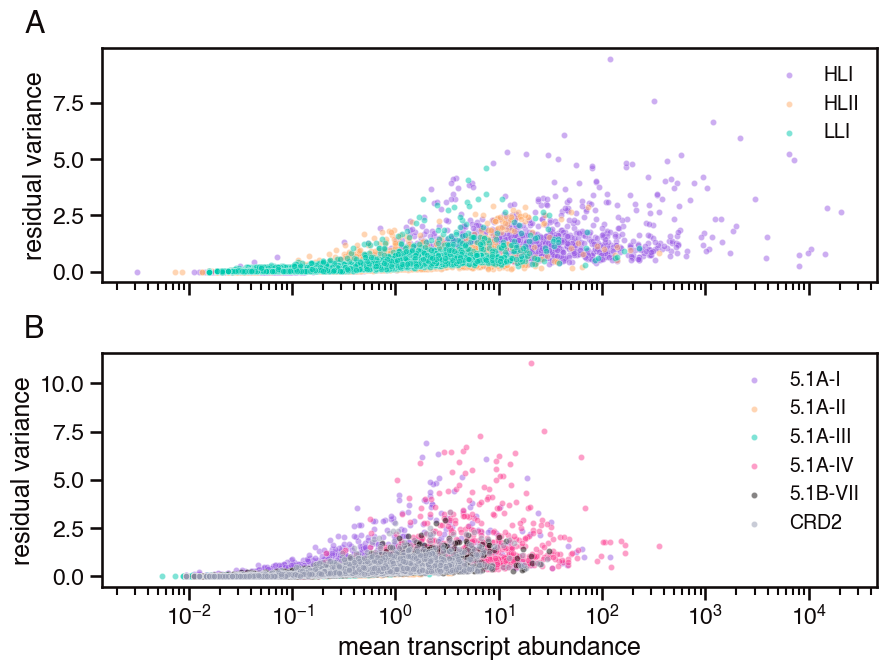

In [7]:
# figure showing post-normalization mean-variance relationship
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, gridspec_kw={'hspace': .3})

# prochlorococcus
ds = pro_ds
# iterate through clades
for i, clade in enumerate(ds.clade.data):
    abundance = ds.sel(clade=clade).readcount.to_pandas()
    residual = ds.sel(clade=clade).residual.to_pandas()
    sns.scatterplot(
        x=abundance.apply(geometric_mean, axis=1), 
        y=residual.var(axis=1), 
        alpha=0.5, 
        s=20, 
        edgecolors=None, 
        color=sns.color_palette()[i], 
        label=clade, 
        legend=False, 
        ax=axes[0]
    )
# set figure parameters and labels
axes[0].annotate('A', xy=(-0.1, 1.1), **annot_kwgs)
axes[0].set(xscale='log', ylabel='residual variance')
axes[0].legend(loc='upper right', fontsize=14)


# synechococcus
ds = syn_ds
# iterate through clades
for i, clade in enumerate(ds.clade.data):
    abundance = ds.sel(clade=clade).readcount.to_pandas()
    residual = ds.sel(clade=clade).residual.to_pandas()
    # fix 'Costa Rica Dome (CRD)' typo
    if clade == 'CDR2':
        clade = 'CRD2'
    sns.scatterplot(
        x=abundance.apply(geometric_mean, axis=1), 
        y=residual.var(axis=1), 
        alpha=0.5, 
        s=20, 
        edgecolors=None, 
        color=sns.color_palette()[i], 
        label=clade, 
        legend=False, 
        ax=axes[1]
    )
# set figure parameters and labels
axes[1].annotate('B', xy=(-0.1, 1.1), **annot_kwgs)
axes[1].set(xscale='log', xlabel='mean transcript abundance', ylabel='residual variance')
axes[1].legend(loc='upper right', fontsize=14)

plt.savefig('postnorm-var-v-mean.png', bbox_inches='tight')


# Post-normalization UMAP analysis

In [16]:
# make dataframes from data tensors

# unfold syn residuals into dataframe
syn_df = syn_ds.residual.to_dataframe().reset_index().pivot(
    index='sample', 
    columns=['ortholog', 'clade']
)

# unfold pro residuals into dataframe
pro_df = pro_ds.residual.to_dataframe().reset_index().pivot(
    index='sample', 
    columns=['ortholog', 'clade']
)

residual_dfs = {
    'pro': pro_df, 
    'syn': syn_df
}


In [17]:
# take slices of each ecotype

residual_dfs = {}
read_counts = {}
coverages = {}
for clade in ['5.1A-I', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1B-VII', 'CDR2']:
    slice_df = syn_ds.sel(clade=clade).residual.to_dataframe().reset_index().pivot(
        index='sample', columns='ortholog', values='residual')
    residual_dfs[clade] = slice_df[slice_df.sum(axis=1) != 0]
    # get read counts
    readcount = syn_ds.sel(clade=clade).readcount.to_dataframe().reset_index().pivot(
        index='sample', columns='ortholog', values='readcount').sum(axis=1)
    readcount.name = 'ReadCount'
    read_counts[clade] = readcount[readcount != 0]
    # get coverages
    coverage = syn_ds.sel(clade=clade).readcount.to_dataframe().reset_index().pivot(
        index='sample', columns='ortholog', values='readcount').gt(0).mean(axis=1)
    coverage.name = 'Coverage'
    coverages[clade] = coverage[coverage != 0]
    
for clade in ['HLI', 'HLII', 'LLI']:
    slice_df = pro_ds.sel(clade=clade).residual.to_dataframe().reset_index().pivot(
        index='sample', columns='ortholog', values='residual')
    residual_dfs[clade] = slice_df[slice_df.sum(axis=1) != 0]
    # get read counts
    readcount = pro_ds.sel(clade=clade).readcount.to_dataframe().reset_index().pivot(
        index='sample', columns='ortholog', values='readcount').sum(axis=1)
    readcount.name = 'ReadCount'
    read_counts[clade] = readcount[readcount != 0]
    # get coverages
    coverage = pro_ds.sel(clade=clade).readcount.to_dataframe().reset_index().pivot(
        index='sample', columns='ortholog', values='readcount').gt(0).mean(axis=1)
    coverage.name = 'Coverage'
    coverages[clade] = coverage[coverage != 0]
    

In [18]:
# UMAP of PCA

# parameters
n_comp_pca = 20
n_comp_umap = 2
seed = 9481 + 4

reduced_dfs = {}

for clade in ['5.1A-I', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1B-VII', 'CDR2', 'HLI', 'HLII', 'LLI']:
    print('\n{}'.format(clade))
    input_df = residual_dfs[clade]
    
    # run PCA
    print('\tRunning PCA with {} components...'.format(n_comp_pca))
    pca_model = PCA(n_components=n_comp_pca, random_state=seed)
    embedding = pca_model.fit_transform(input_df)

    # run UMAP
    print('\tRunning UMAP with {} components...'.format(n_comp_umap))
    umap_model = umap.UMAP(n_components=n_comp_umap, random_state=seed)
    # embedding = umap_model.fit_transform(input_df)
    embedding = umap_model.fit_transform(embedding)

    # merge on metadata
    embedding_df = pd.DataFrame(embedding, index=input_df.index)
    merged_df = pd.merge(embedding_df.reset_index(), sample_df, on='sample', how='left')
    
    # Add total read counts & coverages to merged_df
    merged_df['ReadCount'] = merged_df['sample'].map(read_counts[clade])
    merged_df['Coverage'] = merged_df['sample'].map(coverages[clade])
        
    # save to dictionary
    reduced_dfs[clade] = merged_df



5.1A-I
	Running PCA with 20 components...
	Running UMAP with 2 components...

5.1A-II
	Running PCA with 20 components...
	Running UMAP with 2 components...

5.1A-III
	Running PCA with 20 components...
	Running UMAP with 2 components...

5.1A-IV
	Running PCA with 20 components...
	Running UMAP with 2 components...

5.1B-VII
	Running PCA with 20 components...
	Running UMAP with 2 components...

CDR2
	Running PCA with 20 components...
	Running UMAP with 2 components...

HLI
	Running PCA with 20 components...
	Running UMAP with 2 components...

HLII
	Running PCA with 20 components...
	Running UMAP with 2 components...

LLI
	Running PCA with 20 components...
	Running UMAP with 2 components...



5.1A-I


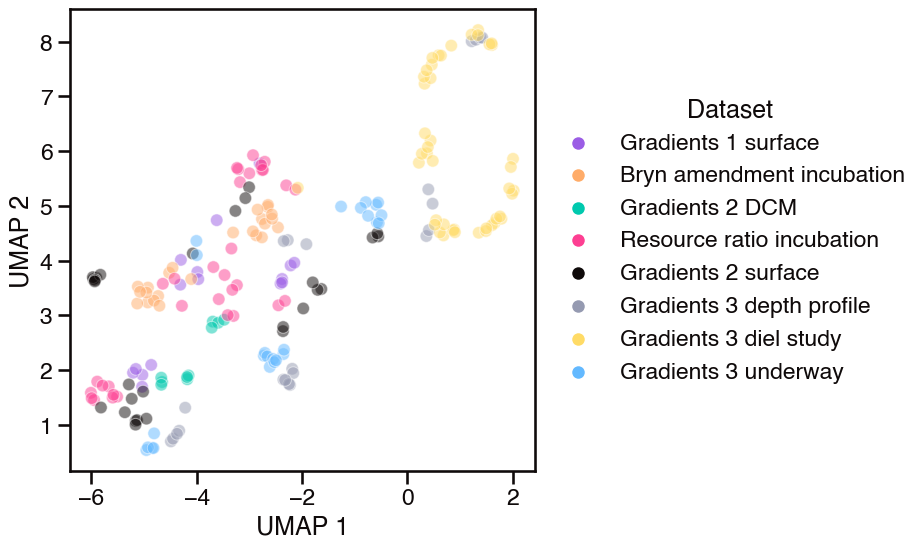

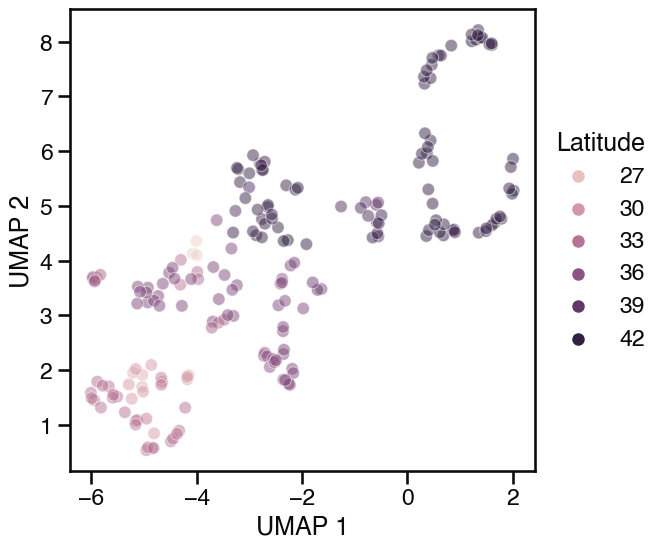

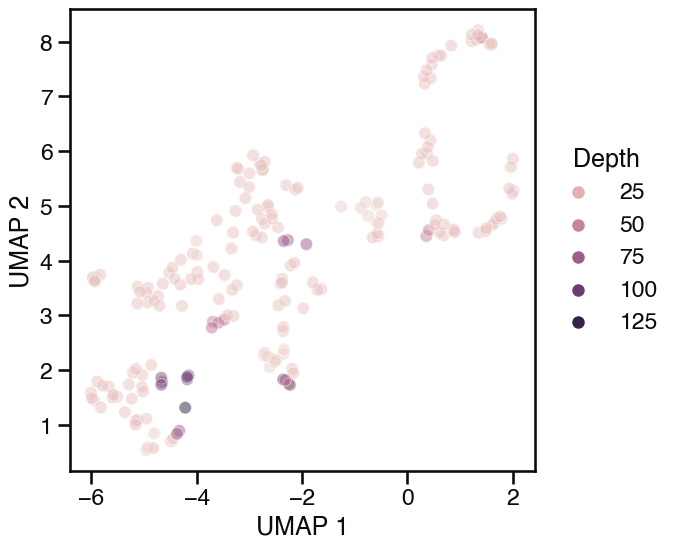

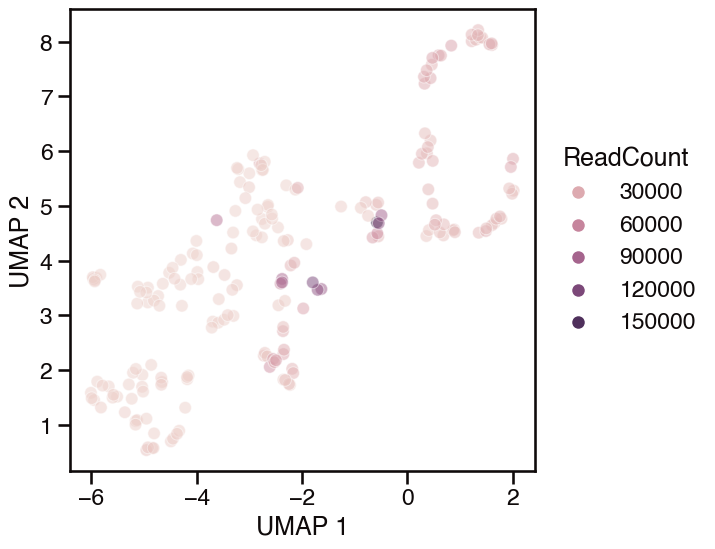

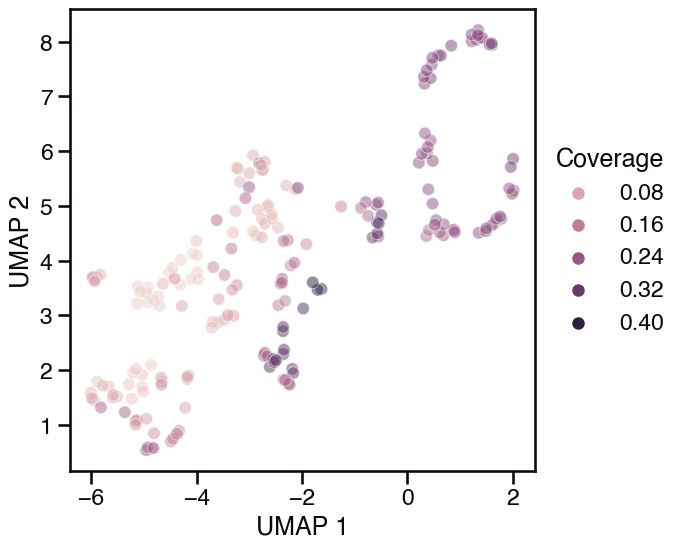


5.1A-II


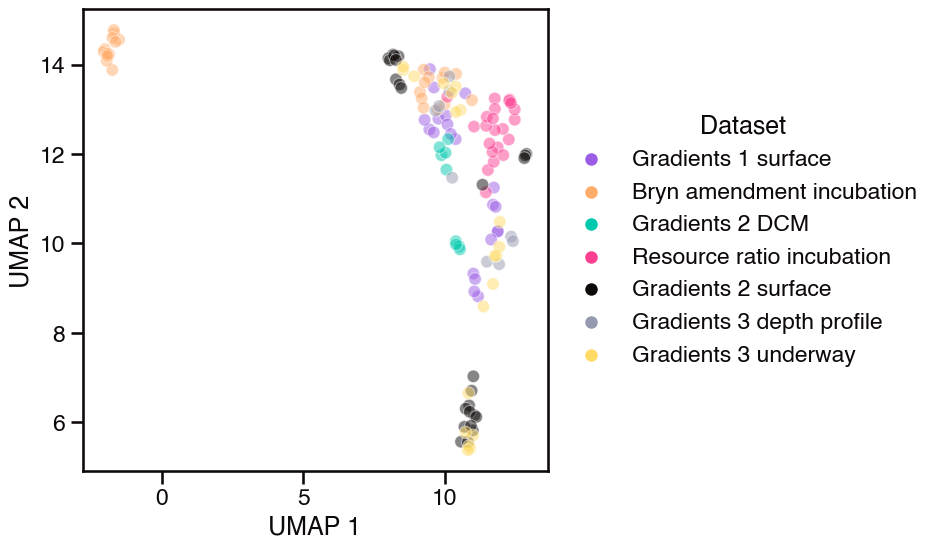

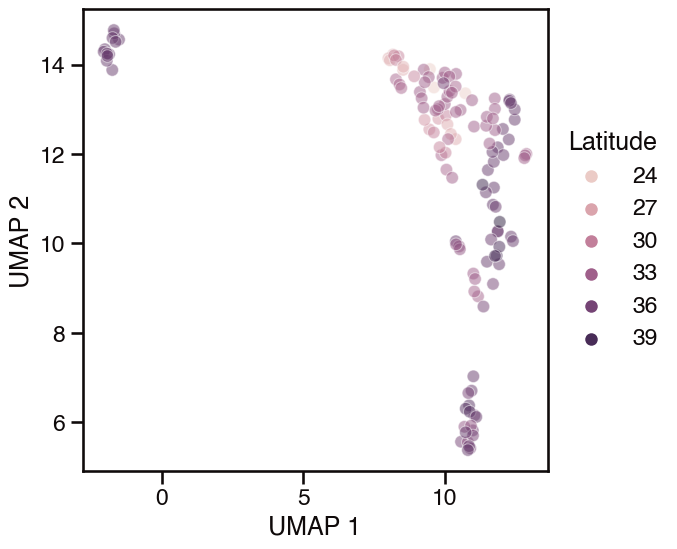

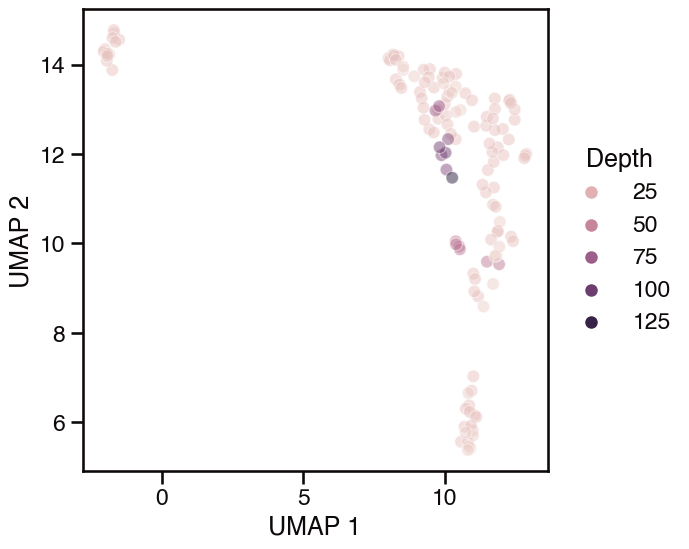

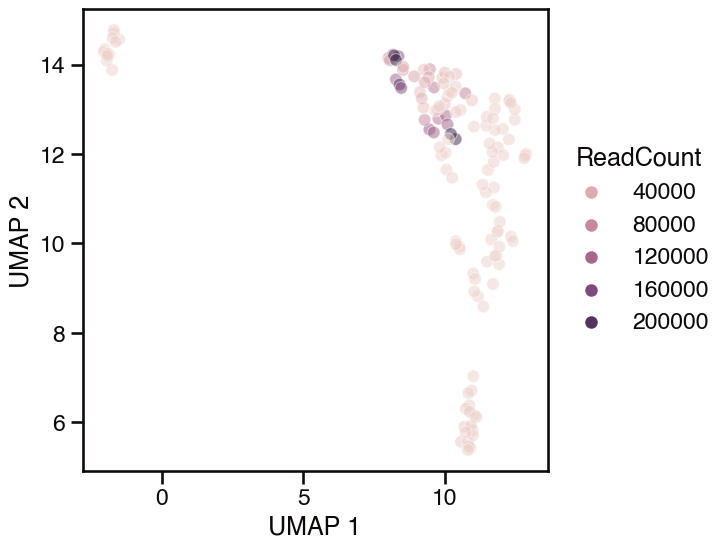

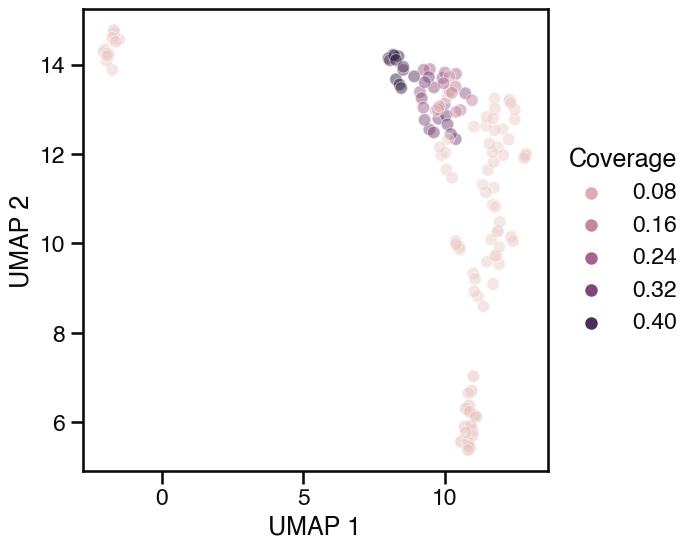


5.1A-III


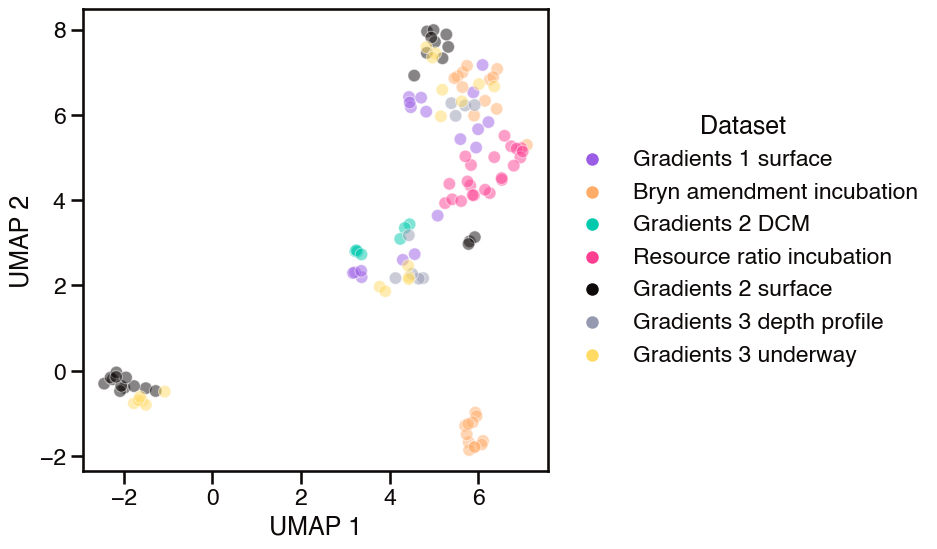

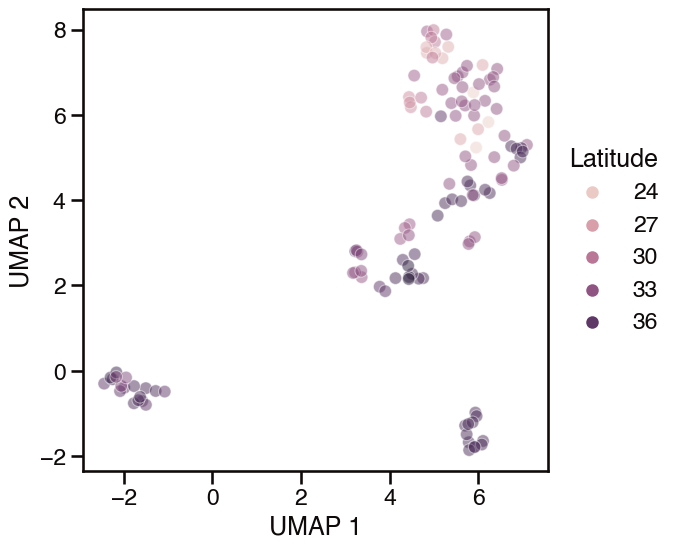

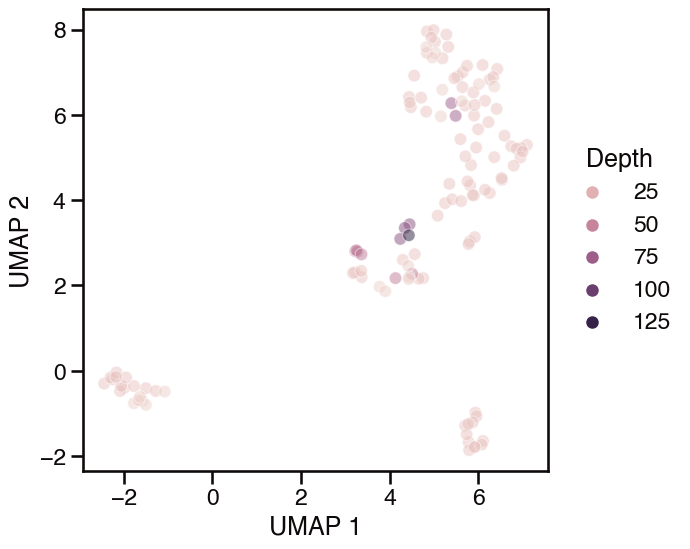

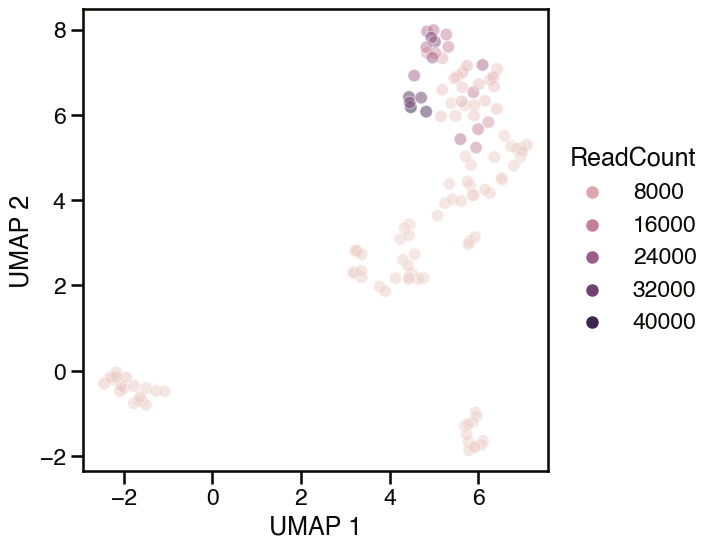

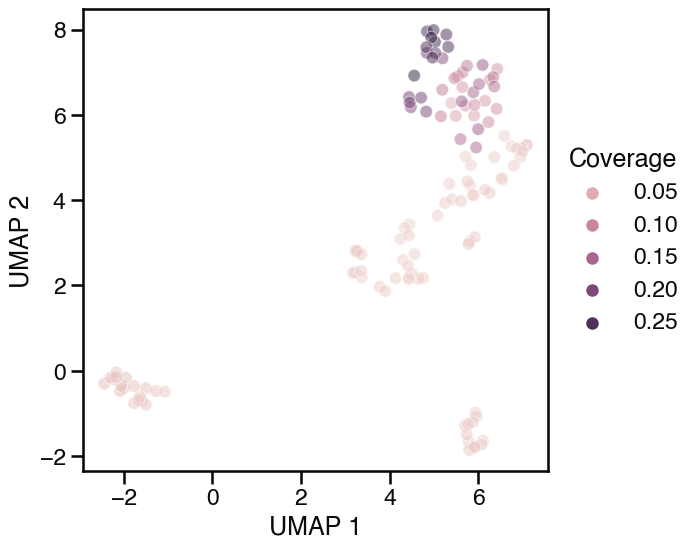


5.1A-IV


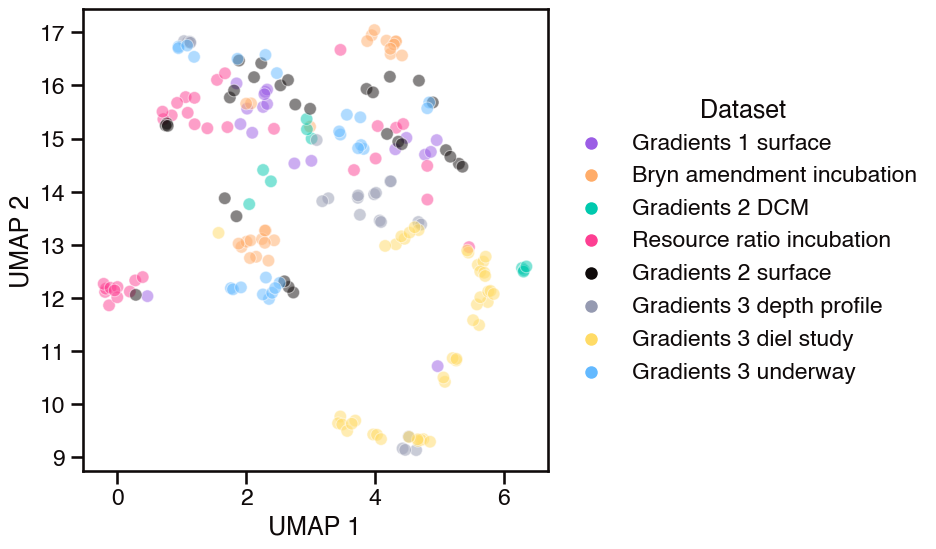

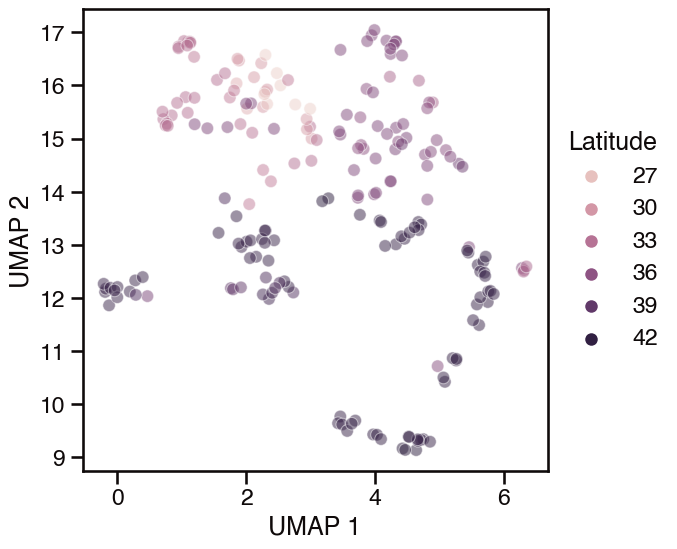

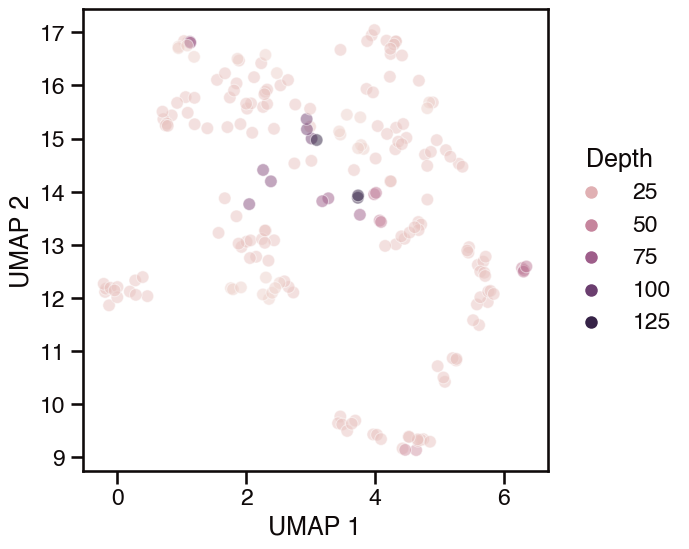

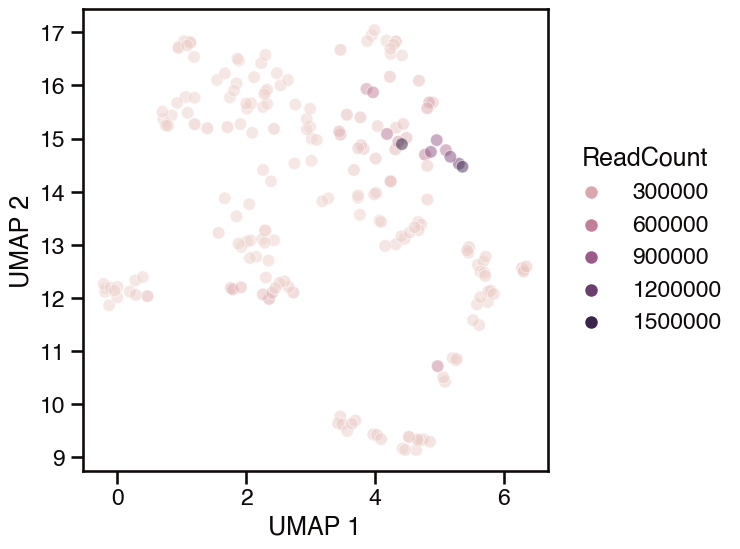

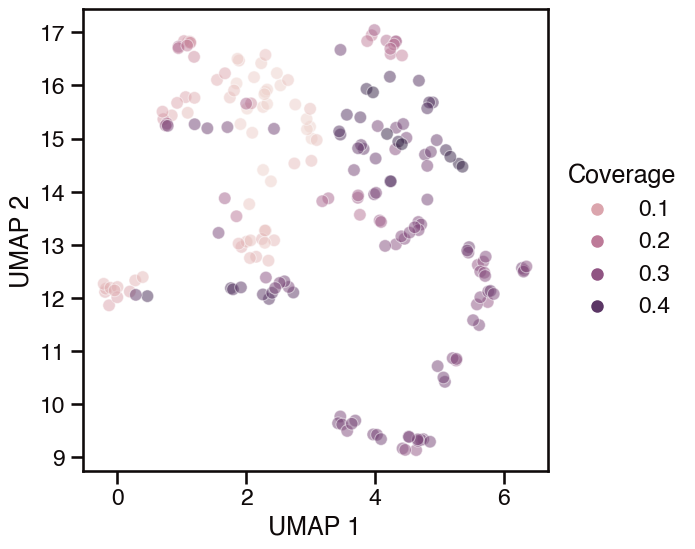


5.1B-VII


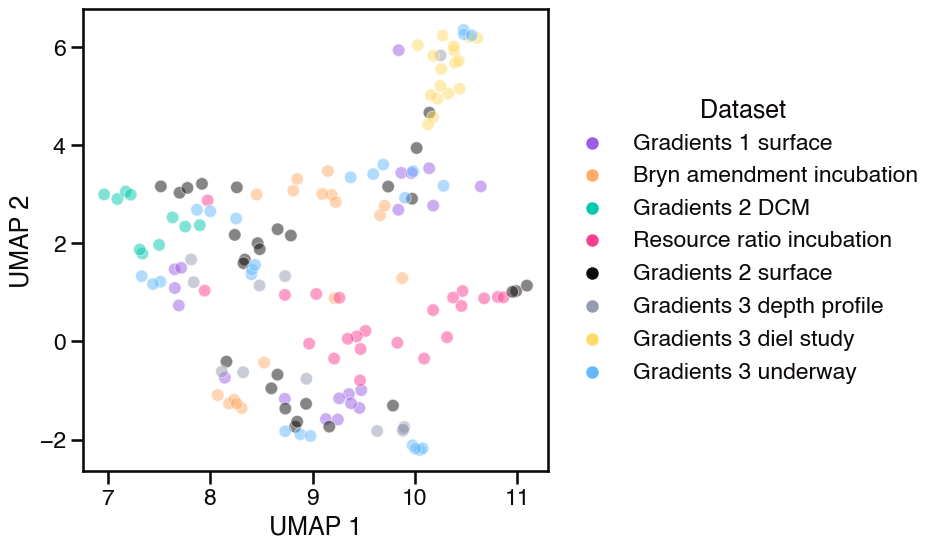

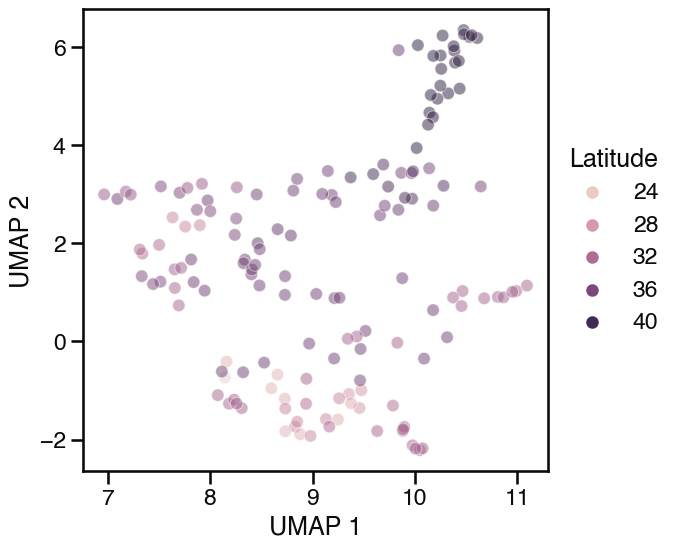

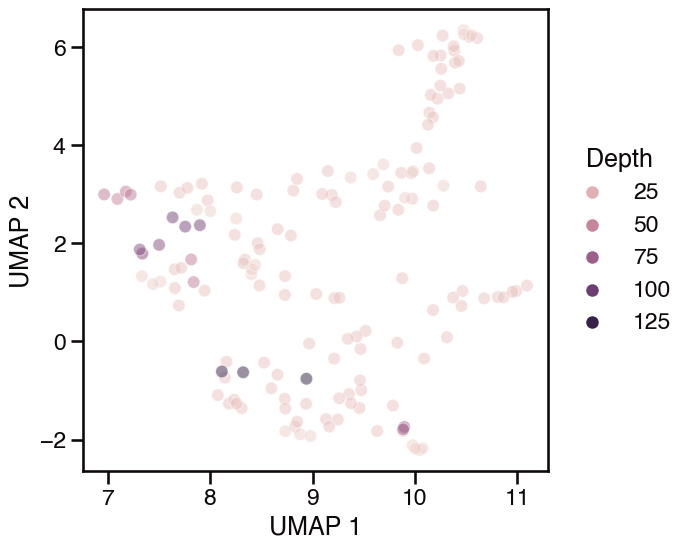

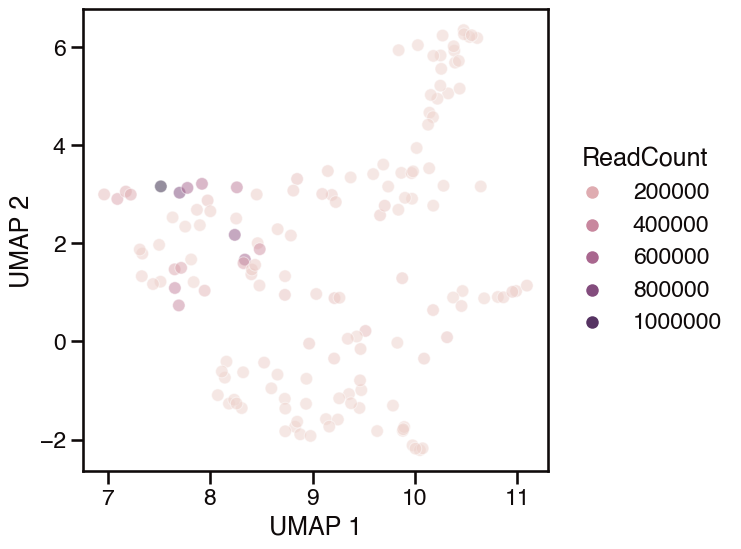

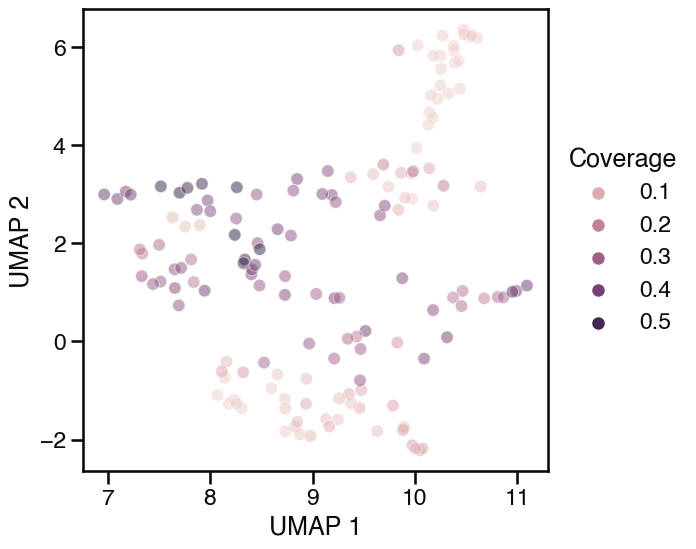


CDR2


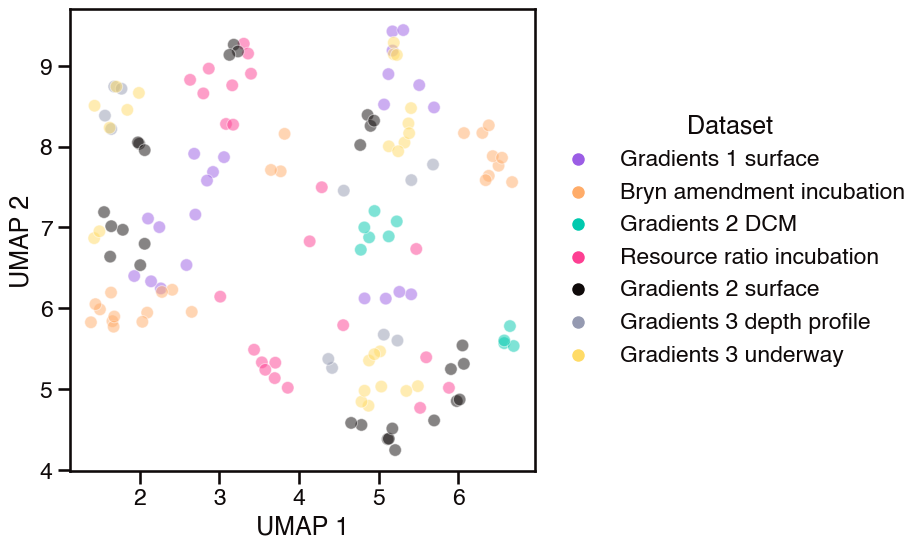

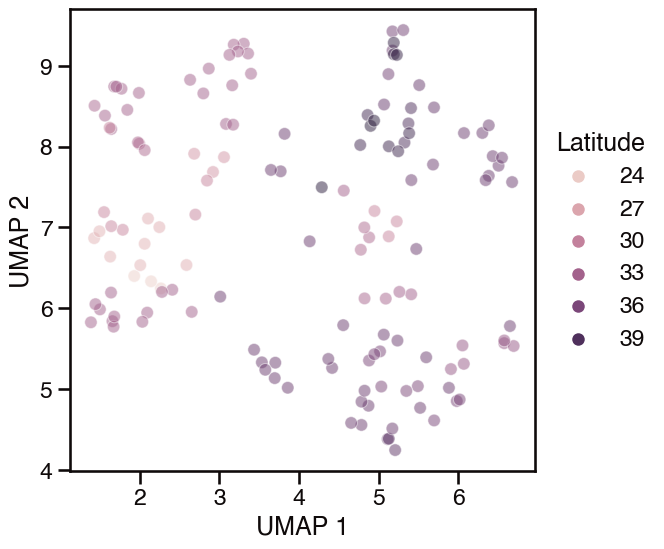

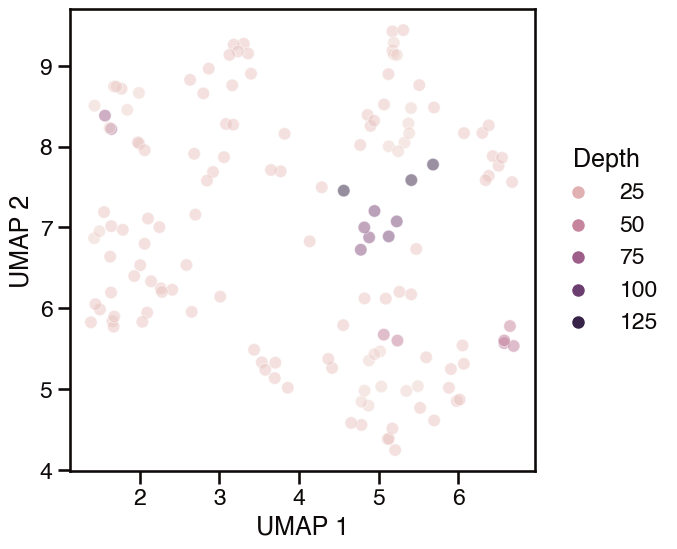

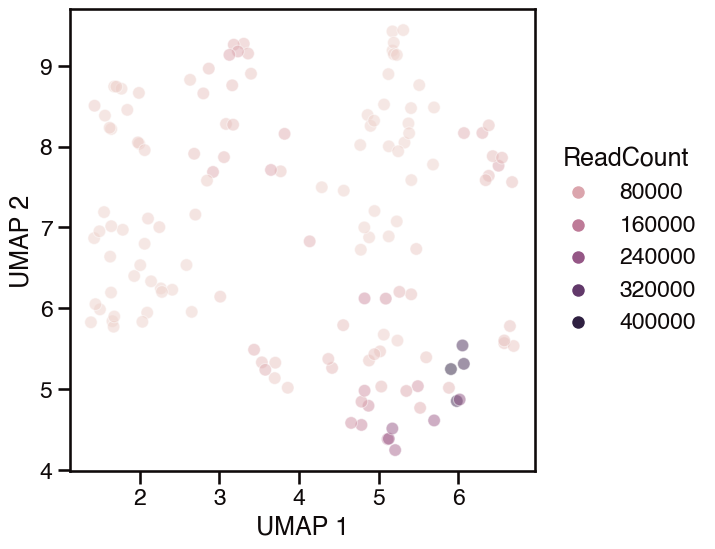

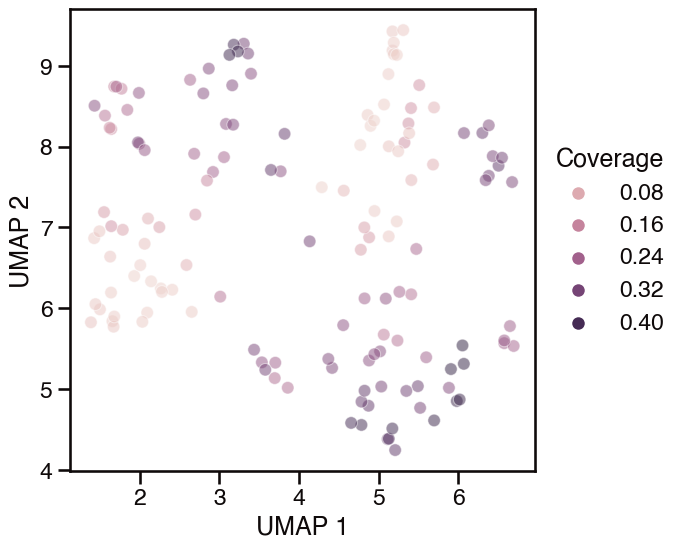


HLI


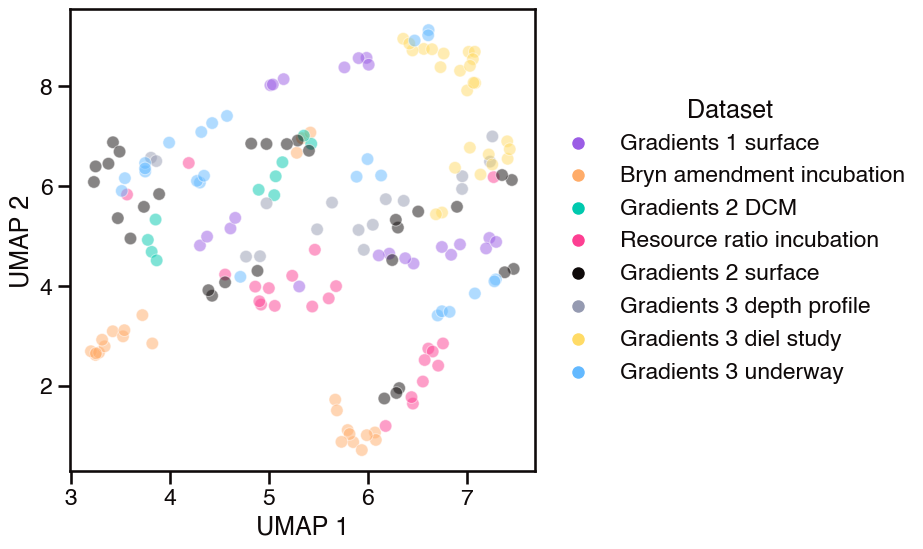

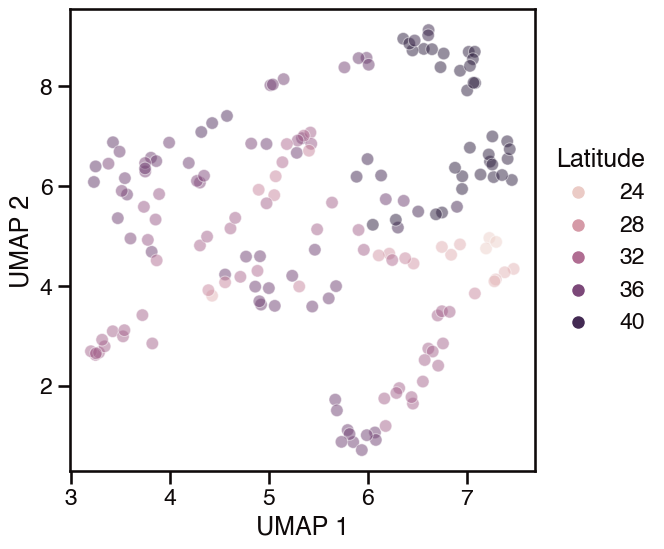

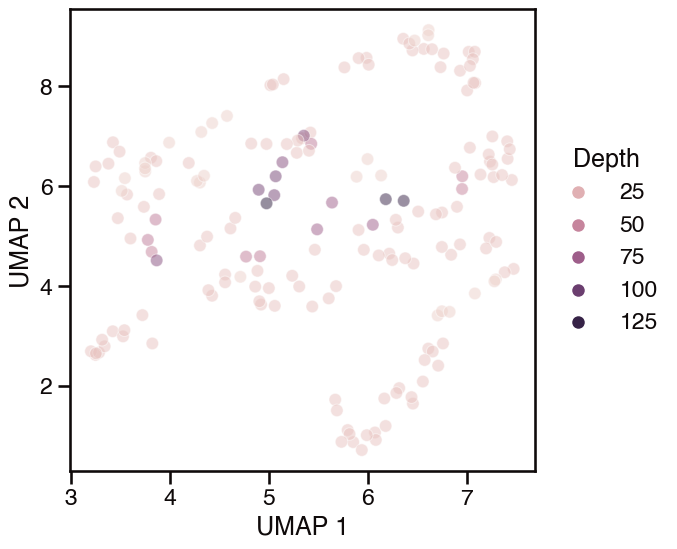

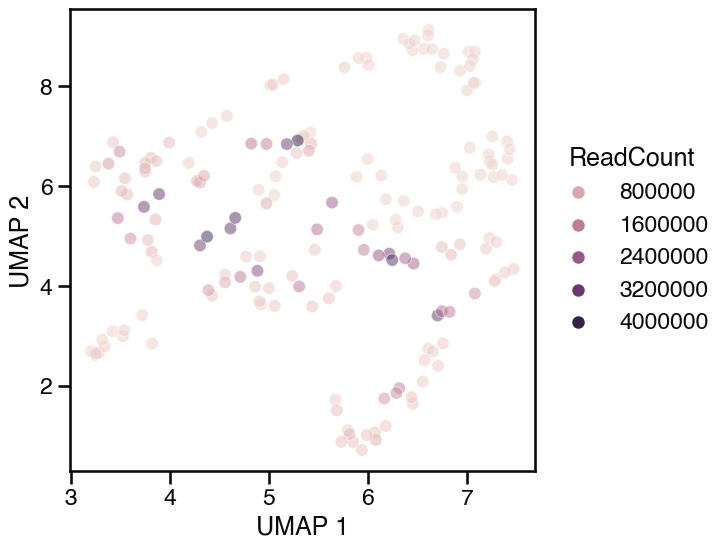

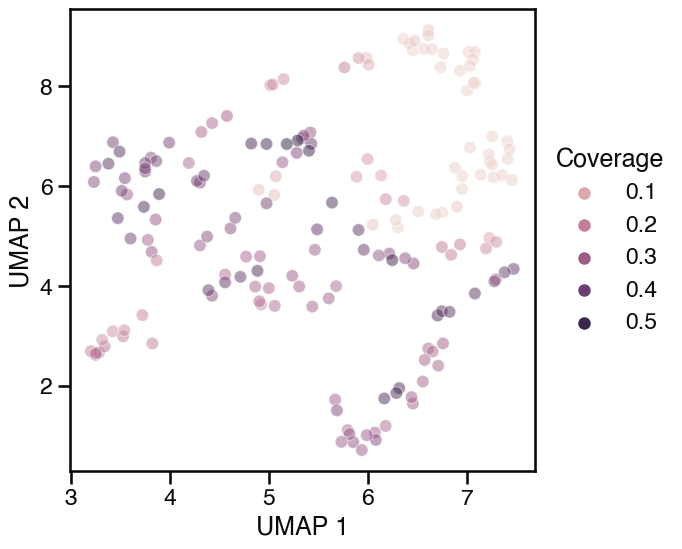


HLII


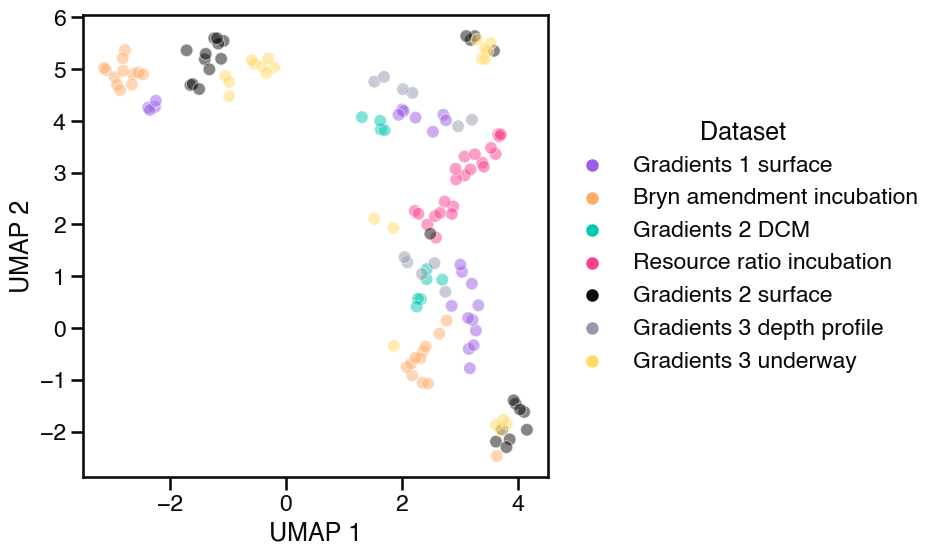

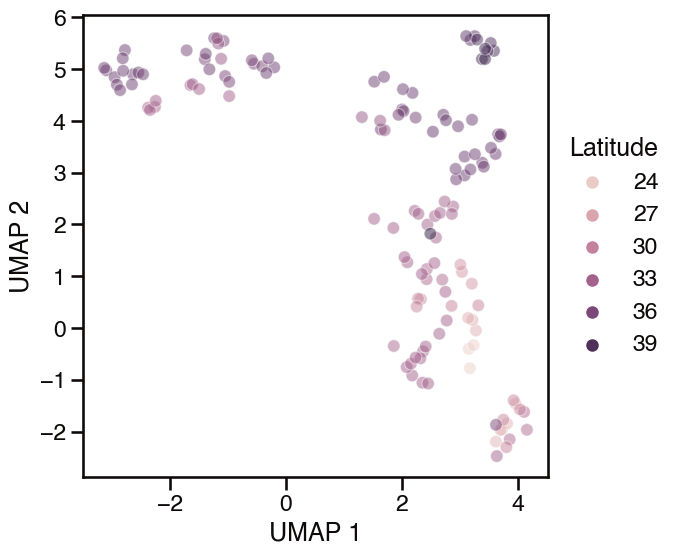

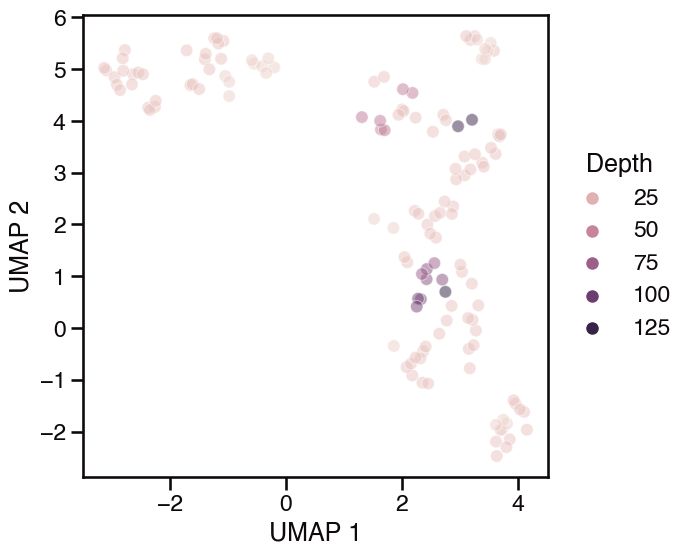

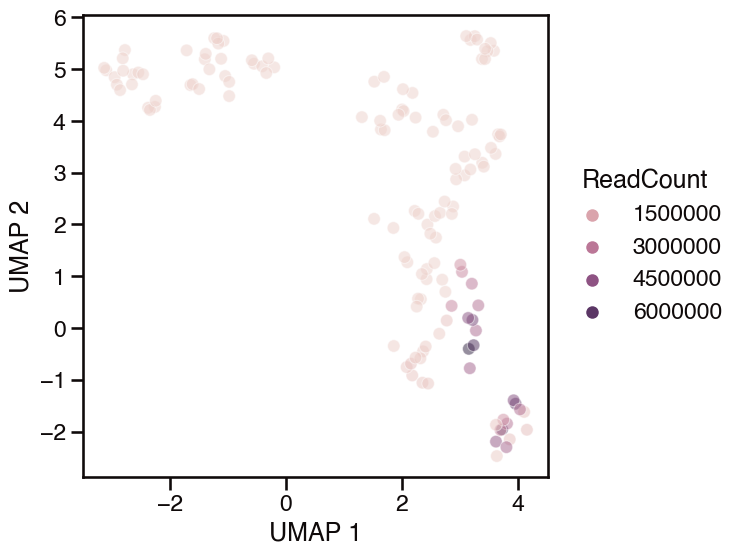

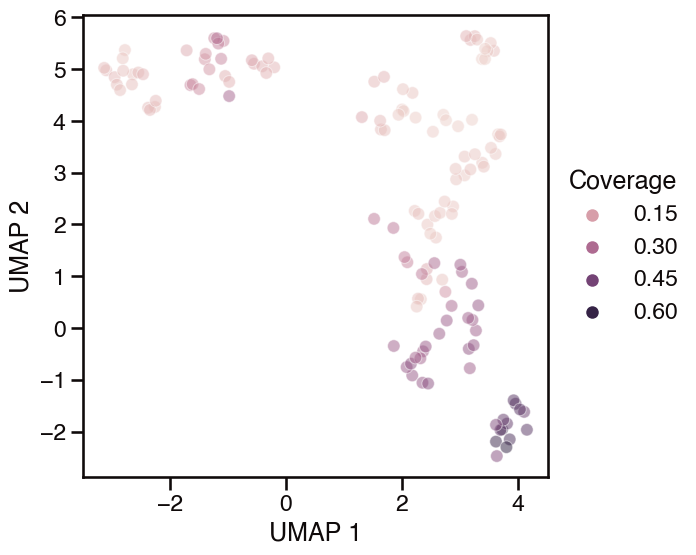


LLI


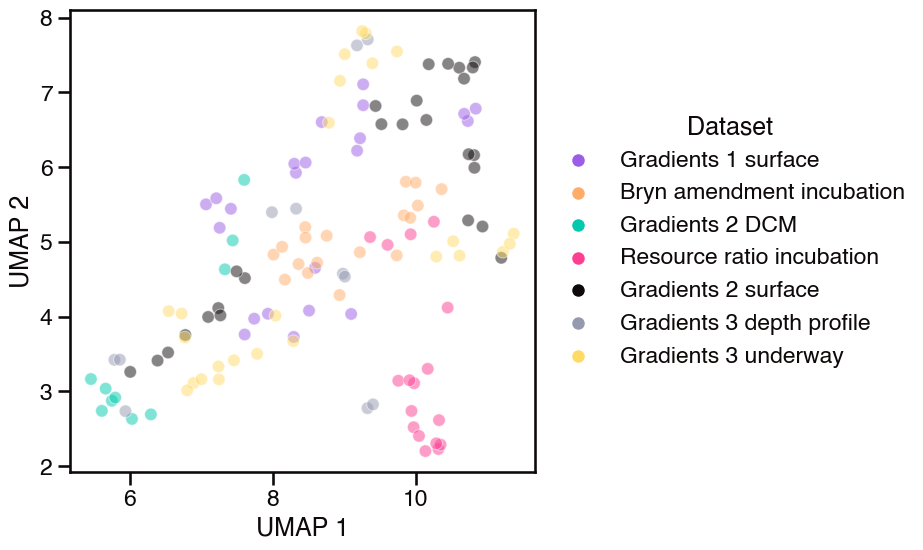

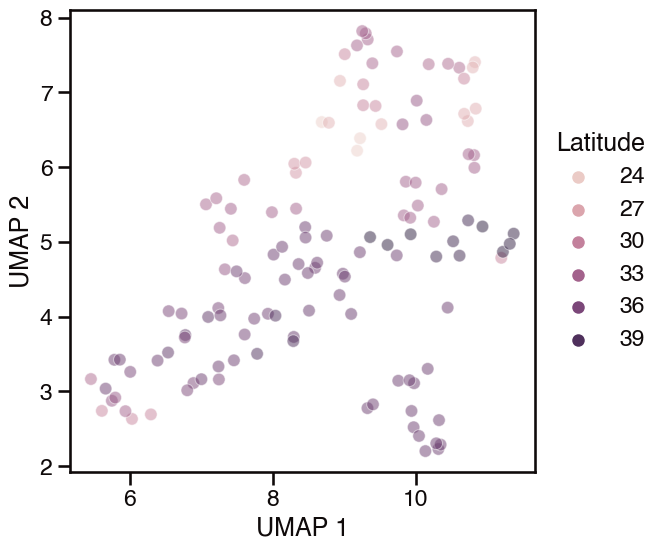

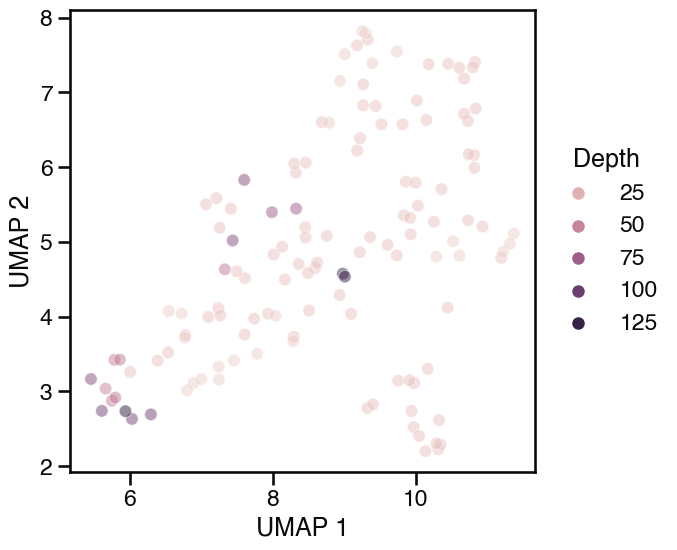

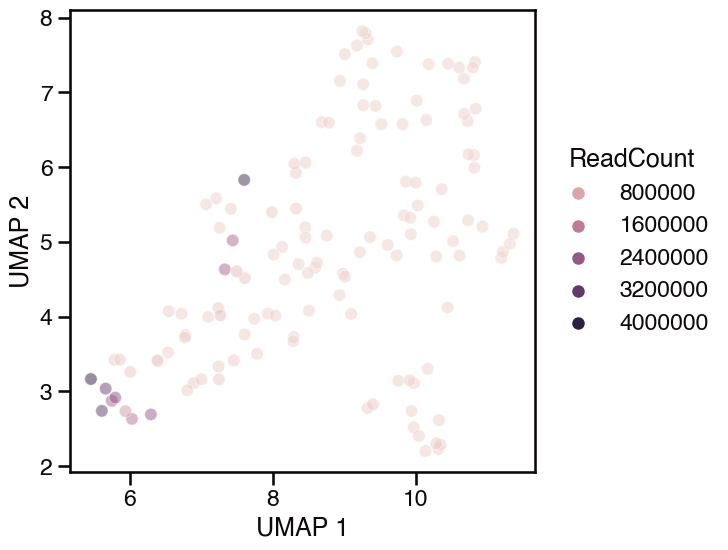

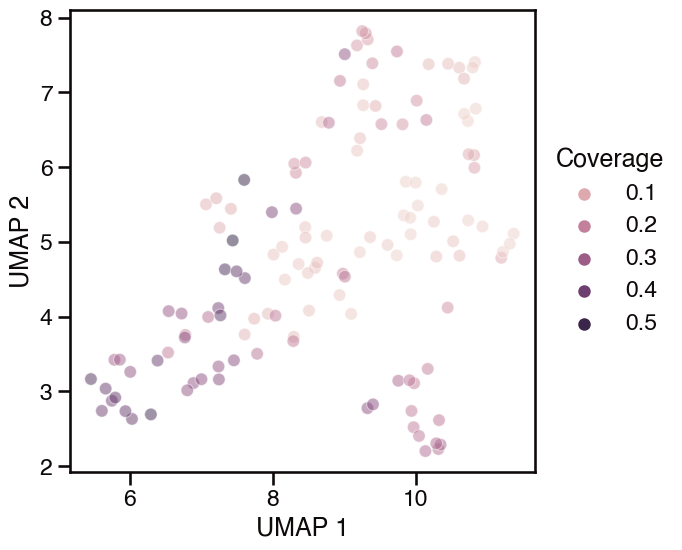

In [19]:
# plot dimensionality-reduced data

# variables = ['Cruise', 'Dataset', 'Latitude', 'Depth', 'replicate', 'Unfractionated']
variables = ['Dataset', 'Latitude', 'Depth', 'ReadCount', 'Coverage']

# plot both datasets
# for genus in ['pro', 'syn']:
#     print('\n{}\n'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus]))
#     plot_df = reduced_dfs[genus]
for clade in ['5.1A-I', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1B-VII', 'CDR2', 'HLI', 'HLII', 'LLI']:
    print('\n{}'.format(clade))
    plot_df = reduced_dfs[clade]
    
    # plot each variable
    for var in variables:
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.scatterplot(x=0, y=1, hue=var, alpha=0.5, data=plot_df, ax=ax)
        plt.legend(title=var, loc='center left', bbox_to_anchor=[1, 0.5]);
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
#         plt.savefig('{}-residuals-umap-{}.png'.format(genus, var), bbox_inches='tight')
        plt.show()


# Look at specific genes

In [22]:
# summarize read count information

clade = 'CDR2'
ds = syn_ds

# select gene data
readcount_df = ds.sel(clade=clade).readcount.to_dataframe().reset_index()

# make sample summary df
sample_summary_df = readcount_df.groupby('sample').agg(MeanReads=('readcount', 'mean'),
                                                       TotalReads=('readcount', 'sum'), 
                                                       GeomMeanReads=('readcount', geometric_mean))

# calculate scaling factor
mean_total_reads = sample_summary_df.TotalReads.mean()
sample_summary_df['ScalingFactor'] = sample_summary_df['TotalReads'] / mean_total_reads

# calculate logs
sample_summary_df = sample_summary_df[sample_summary_df['MeanReads'] != 0].reset_index()
sample_summary_df['LogMeanReads'] = np.log10(sample_summary_df['MeanReads'])
sample_summary_df['LogTotalReads'] = np.log10(sample_summary_df['TotalReads'])
sample_summary_df['LogGeomMeanReads'] = np.log10(sample_summary_df['GeomMeanReads'])

# add in sample info
sample_summary_df['Cruise'] = sample_summary_df['sample'].map(sample_df.set_index('sample')['Cruise'])
sample_summary_df['Dataset'] = sample_summary_df['sample'].map(sample_df.set_index('sample')['Dataset'])
sample_summary_df['Latitude'] = sample_summary_df['sample'].map(sample_df.set_index('sample')['Latitude'])

sample_summary_df

sample  MeanReads  TotalReads  GeomMeanReads  \
0    G1.SURF.NS.S02C1.15m.A   0.077323     476.390       0.010922   
1    G1.SURF.NS.S02C1.15m.B   0.103852     639.830       0.016132   
2    G1.SURF.NS.S02C1.15m.C   0.084299     519.369       0.014645   
3    G1.SURF.NS.S04C1.15m.A   7.013486   43210.086       0.672656   
4    G1.SURF.NS.S04C1.15m.B  11.149848   68694.213       0.828041   
..                      ...        ...         ...            ...   
138    G3.UW.NS.UW40_1.7m.B   0.065832     405.593       0.014081   
139    G3.UW.NS.UW40_1.7m.C   0.073722     454.200       0.012067   
140    G3.UW.NS.UW40_2.7m.A   0.078470     483.453       0.034430   
141    G3.UW.NS.UW40_2.7m.B   0.040984     252.500       0.020688   
142    G3.UW.NS.UW40_2.7m.C   0.080182     494.002       0.033363   

     ScalingFactor  LogMeanReads  LogTotalReads  LogGeomMeanReads Cruise  \
0         0.017143     -1.111689       2.677963         -1.961691     G1   
1         0.023025     -0.983587       2.806065         -1.792308     G1   
2         0.018690     -1.074175       2.715476         -1.834319     G1   
3         1.554957      0.845934       4.635585         -0.172207     G1   
4         2.472029      1.047269       4.836920         -0.081948     G1   
..             ...           ...            ...               ...    ...   
138       0.014596     -1.181561       2.608090         -1.851364     G3   
139       0.016345     -1.132404       2.657247         -1.918385     G3   
140       0.017398     -1.105297       2.684354         -1.463058     G3   
141       0.009086     -1.387390       2.402261         -1.684281     G3   
142       0.017777     -1.095923       2.693729         -1.476735     G3   

                  Dataset   Latitude  
0     Gradients 1 surface  23.495833  
1     Gradients 1 surface  23.495833  
2     Gradients 1 surface  23.495833  
3     Gradients 1 surface  28.143167  
4     Gradients 1 surface  28.143167  
..                    ...        ...  
138  Gradients 3 underway  40.880000  
139  Gradients 3 underway  40.880000  
140  Gradients 3 underway  40.090000  
141  Gradients 3 underway  40.090000  
142  Gradients 3 underway  40.090000  

[143 rows x 11 columns]

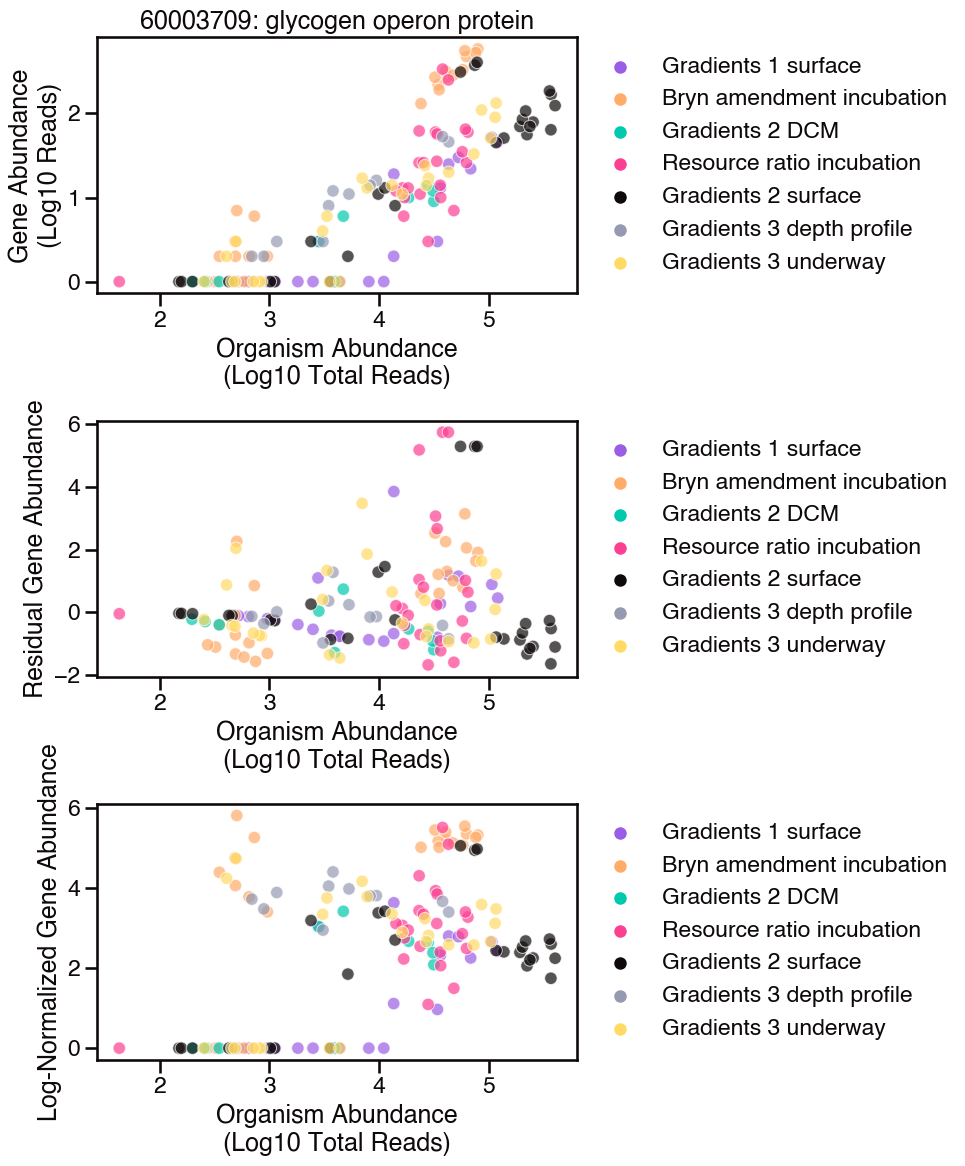

In [47]:
# plot transcripts and abundances of a specific gene

gene = 60003709
pseudocount = 1
# pseudocount = 1 / (10 * 4) # pro overdispersion factor

# pull out specific gene abundance
annotation = ds.sel(clade=clade, ortholog=gene).annotation.data.flatten()[0]
gene_df = sample_summary_df.join(
    ds.sel(clade=clade, ortholog=gene).readcount.to_dataframe().readcount.rename('GeneReads'), 
    on='sample'
)
gene_df = gene_df.join(
    ds.sel(clade=clade, ortholog=gene).residual.to_dataframe().residual.rename('residual'), 
    on='sample'
)
gene_df['LogGeneReads'] = np.log10(gene_df['GeneReads'] + pseudocount)
gene_df['LogNormedGeneReads'] = np.log(gene_df['GeneReads'] / gene_df['ScalingFactor'] + pseudocount)

# plot gene relationship
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
sns.scatterplot(
    x='LogTotalReads', 
    y='LogGeneReads', 
    hue='Dataset', 
    alpha=0.7, 
    data=gene_df, 
    ax=ax[0]
)
ax[0].set(
    xlabel='Organism Abundance\n(Log10 Total Reads)', 
    ylabel='Gene Abundance\n(Log10 Reads)', 
    title='{}: {}'.format(gene, annotation)
);
ax[0].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
# plot residuals
sns.scatterplot(
    x='LogTotalReads', 
    y='residual', 
    hue='Dataset', 
    alpha=0.7, 
    data=gene_df, 
    ax=ax[1]
)
ax[1].set(
    xlabel='Organism Abundance\n(Log10 Total Reads)', 
    ylabel='Residual Gene Abundance', 
);
ax[1].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
# plot log norm
sns.scatterplot(
    x='LogTotalReads', 
    y='LogNormedGeneReads', 
    hue='Dataset', 
    alpha=0.7, 
    data=gene_df, 
    ax=ax[2]
)
ax[2].set(
    xlabel='Organism Abundance\n(Log10 Total Reads)', 
    ylabel='Log-Normalized Gene Abundance', 
);
ax[2].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
fig.tight_layout()

# save figure
plt.savefig('{}_count_residual_v_total_reads.png'.format(gene))
plt.show()


In [50]:
gene_df[gene_df['Dataset'] == 'Gradients 2 surface'][
    ['sample', 'LogTotalReads', 'LogGeneReads', 'residual', 'LogNormedGeneReads']
]

sample  LogTotalReads  LogGeneReads  residual  \
79   G2.SURF.NS.S02C1.15m.A       3.047025      0.000000 -0.268023   
80   G2.SURF.NS.S02C1.15m.B       3.007256      0.000000 -0.244570   
81   G2.SURF.NS.S02C1.15m.C       2.659689      0.000000 -0.109859   
82   G2.SURF.NS.S05C1.15m.A       5.569045      1.806200 -1.647347   
83   G2.SURF.NS.S05C1.15m.B       5.350877      1.748180 -1.332051   
84   G2.SURF.NS.S05C1.15m.C       5.406696      1.897627 -1.091700   
85   G2.SURF.NS.S06C1.15m.B       2.173172      0.000000 -0.035836   
86   G2.SURF.NS.S06C1.15m.C       2.629270      0.000000 -0.102427   
87   G2.SURF.NS.S07C1.15m.A       2.196115      0.000000 -0.037780   
88   G2.SURF.NS.S07C1.15m.C       2.297432      0.000000 -0.047707   
89   G2.SURF.NS.S09C1.15m.A       5.286492      1.845098 -0.881566   
90   G2.SURF.NS.S09C1.15m.B       5.309244      1.929419 -0.660952   
91   G2.SURF.NS.S09C1.15m.C       5.338438      2.029384 -0.364741   
92   G2.SURF.NS.S11C1.15m.A       5.140109      1.707570 -0.851969   
93   G2.SURF.NS.S11C1.15m.B       5.377176      1.845098 -1.155560   
94   G2.SURF.NS.S11C1.15m.C       5.068814      1.653213 -0.794271   
95   G2.SURF.NS.S15C1.15m.A       5.571231      2.225307 -0.521895   
96   G2.SURF.NS.S15C1.15m.B       5.556251      2.267172 -0.267092   
97   G2.SURF.NS.S15C1.15m.C       5.607761      2.093422 -1.108420   
98   G2.SURF.NS.S16C1.15m.A       4.743949      2.492760  5.291503   
99   G2.SURF.NS.S16C1.15m.B       4.873897      2.574032  5.291503   
100  G2.SURF.NS.S16C1.15m.C       4.895593      2.608520  5.291503   
101  G2.SURF.NS.S17C1.15m.A       3.992436      1.041393  1.280163   
102  G2.SURF.NS.S17C1.15m.B       4.146490      0.903090 -0.244522   
103  G2.SURF.NS.S17C1.15m.C       4.053415      1.113943  1.456664   
104  G2.SURF.NS.S18C1.15m.A       3.379188      0.477121  0.257690   
105  G2.SURF.NS.S18C1.15m.B       3.557864      0.000000 -0.868981   
106  G2.SURF.NS.S18C1.15m.C       3.715487      0.301030 -0.832538   

     LogNormedGeneReads  
79             0.000000  
80             0.000000  
81             0.000000  
82             1.744426  
83             2.055802  
84             2.250976  
85             0.000000  
86             0.000000  
87             0.000000  
88             0.000000  
89             2.389994  
90             2.521926  
91             2.675008  
92             2.403606  
93             2.202240  
94             2.436707  
95             2.599362  
96             2.721608  
97             2.244273  
98             5.052024  
99             4.941249  
100            4.970696  
101            3.376796  
102            2.700202  
103            3.417305  
104            3.186840  
105            0.000000  
106            1.848505

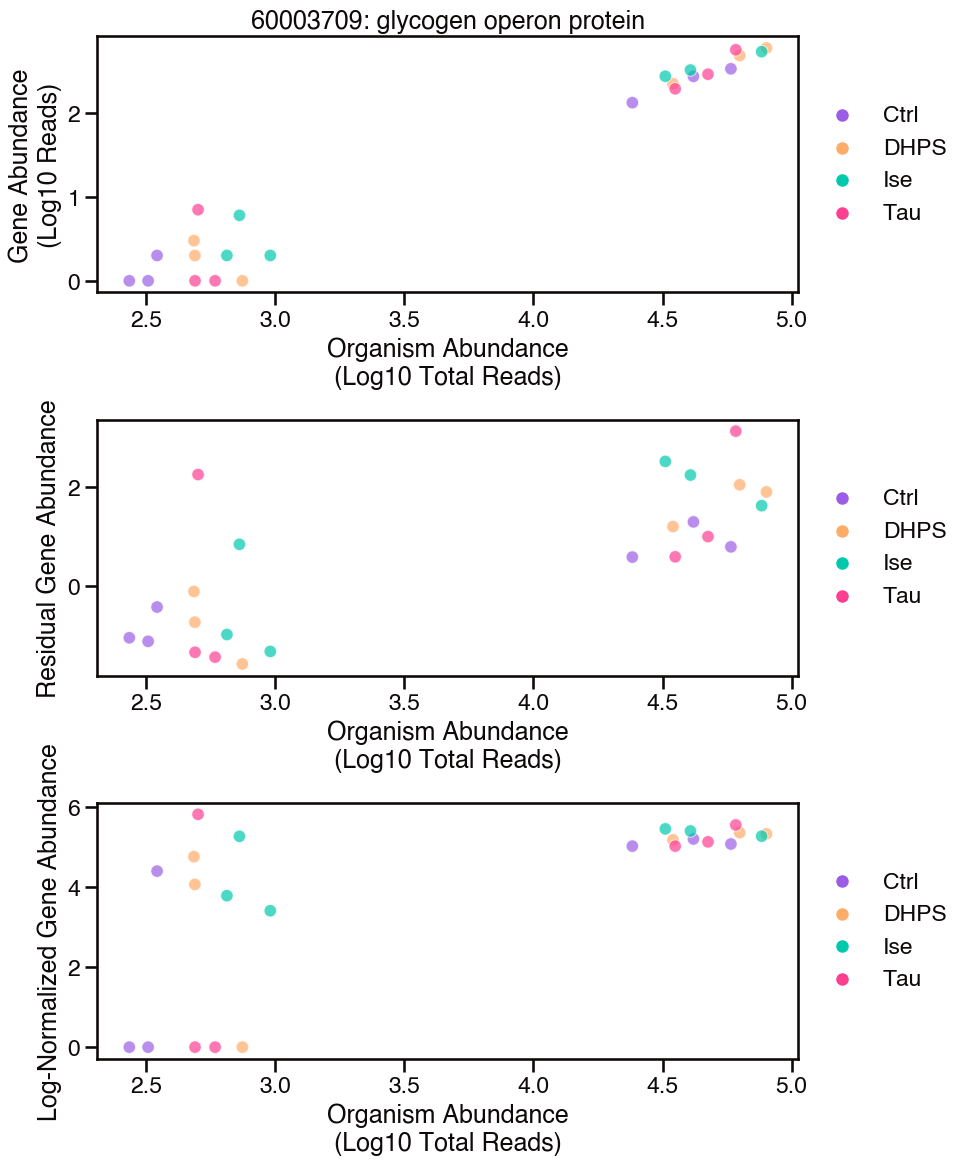

In [44]:

# ['Gradients 1 surface', 'Bryn amendment incubation',
#        'Gradients 2 DCM', 'Resource ratio incubation',
#        'Gradients 2 surface', 'Gradients 3 depth profile',
#        'Gradients 3 underway']
gene_df = gene_df[gene_df['Dataset'] == 'Bryn amendment incubation']
gene_df['Experiment'] = gene_df['sample'].map(sample_df.set_index('sample')['Experiment'])
gene_df = gene_df.join(gene_df['Experiment'].str.split(' ', expand=True))

# plot gene relationship
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
sns.scatterplot(
    x='LogTotalReads', 
    y='LogGeneReads', 
    hue=1, 
    alpha=0.7, 
    data=gene_df, 
    ax=ax[0]
)
ax[0].set(
    xlabel='Organism Abundance\n(Log10 Total Reads)', 
    ylabel='Gene Abundance\n(Log10 Reads)', 
    title='{}: {}'.format(gene, annotation)
);
ax[0].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
# plot residuals
sns.scatterplot(
    x='LogTotalReads', 
    y='residual', 
    hue=1, 
    alpha=0.7, 
    data=gene_df, 
    ax=ax[1]
)
ax[1].set(
    xlabel='Organism Abundance\n(Log10 Total Reads)', 
    ylabel='Residual Gene Abundance', 
);
ax[1].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
# plot log norm
sns.scatterplot(
    x='LogTotalReads', 
    y='LogNormedGeneReads', 
    hue=1, 
    alpha=0.7, 
    data=gene_df, 
    ax=ax[2]
)
ax[2].set(
    xlabel='Organism Abundance\n(Log10 Total Reads)', 
    ylabel='Log-Normalized Gene Abundance', 
);
ax[2].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
fig.tight_layout()

<Axes: xlabel='1', ylabel='LogNormedGeneReads'>

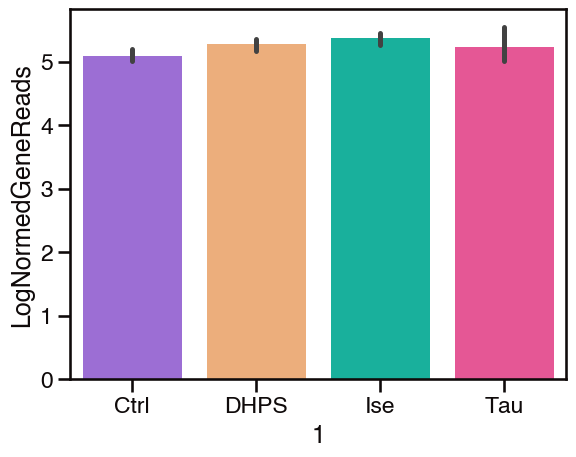

In [46]:
sns.barplot(data=gene_df[gene_df[0] == 'BEXP2'], x=1, y='LogNormedGeneReads', )

In [51]:
!pwd

/Users/blasks/writing/stromatolite-paper/figures/normalization-test
